## Notebook based on transfer_learn.py
* used a notebook so that i can store the outputs and screenshot them whenever required

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
import time
import os
import copy
from sklearn.metrics import confusion_matrix
from utils import cf_matrix
import seaborn as sns


### data preprocessing

In [13]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}


### dataloaders

In [14]:
data_dir = './data/hyphaAug'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform=data_transforms[x])
                                        # transform=transforms.ToTensor())
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # contam, no_contam

['contam', 'no_contam']


In [9]:
# obtain initial shape
img, label = image_datasets['test'][8]
print(f"initial image shape: {img.shape} ")
print(f"label: {label} ")
print(len(image_datasets['train']))
print(len(image_datasets['test'])) # 52
print(len(image_datasets['train'].targets))
print(img)

initial image shape: torch.Size([3, 256, 256]) 
label: 0 
205
52
205
tensor([[[-1.7647, -1.7647, -1.7647,  ...,  0.7922,  0.7137,  0.6980],
         [-1.7647, -1.7647, -1.7647,  ...,  0.8235,  0.7451,  0.7294],
         [-1.7647, -1.7647, -1.7647,  ...,  0.9490,  0.9020,  0.9020],
         ...,
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8902, -1.8902, -1.8902]],

        [[-1.7647, -1.7647, -1.7647,  ...,  0.7137,  0.6667,  0.6510],
         [-1.7647, -1.7647, -1.7647,  ...,  0.7451,  0.6980,  0.6824],
         [-1.7647, -1.7647, -1.7647,  ...,  0.8706,  0.8392,  0.8392],
         ...,
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745],
         [-1.8902, -1.8902, -1.8902,  ..., -1.8745, -1.8745, -1.8745]],

        [[-1.7333, -1.7333, -1.7333,  ...,  0.4

### look at my images

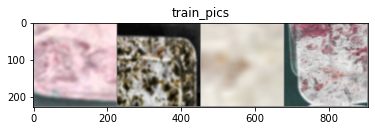

torch.Size([4, 3, 224, 224])


In [5]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

# show training data

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, "train_pics")
print(inputs.shape)

### define own CNN

In [5]:

class ConvNet(nn.Module):
    def __init__(self, image_dim):
        super(ConvNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 6, 5)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        # self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # self.fc2 = nn.Linear(120, 84)
        # self.fc3 = nn.Linear(84, 10)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(186624, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)


    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 186624)            # -> n, 400
        # x = x.flatten()
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x
print(ConvNet(224)) # input has shape torch.Size([4, 3, 224, 224])
convModel = ConvNet(224)
# convModel(inputs)
summary(convModel, (3, 224, 224))

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (fc1): Linear(in_features=186624, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]             896
         MaxPool2d-2         [-1, 32, 111, 111]               0
            Conv2d-3         [-1, 64, 109, 109]          18,496
         MaxPool2d-4           [-1, 64, 54, 54]               0
            Linear-5                  [-1, 120]      22,395,000
            Linear-6                   [-1, 84]          10,164
            Linear-7                    [-1, 2]             170
Tota

In [37]:

# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         # self.conv1 = nn.Conv2d(3, 6, 5)
#         # self.pool = nn.MaxPool2d(2, 2)
#         # self.conv2 = nn.Conv2d(6, 16, 5)
#         # self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         # self.fc2 = nn.Linear(120, 84)
#         # self.fc3 = nn.Linear(84, 10)
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1),
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(2, 2) # output: 64 x 16 x 16
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
#         self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
#         self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
#         self.fc1 = nn.Linear(256*4*4, 1024)
#         self.fc2 = nn.Linear(1024, 512)
#         self.fc3 = nn.Linear(512, 2)

#     def forward(self, x):
#         # -> n, 3, 32, 32
#         x = self.pool(F.relu(self.conv1(x))) 
#         x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
#         x = self.pool(F.relu(self.conv3(x)))
#         x = self.pool(F.relu(self.conv4(x)))
#         x = self.pool(F.relu(self.conv5(x)))
#         x = self.pool(F.relu(self.conv6(x)))
#         x = x.view(-1, 373248)            # -> n, 400
#         x = F.relu(self.fc1(x))               # -> n, 120
#         x = F.relu(self.fc2(x))               # -> n, 84
#         x = self.fc3(x)                       # -> n, 10
#         return x
# print(ConvNet()) # input has shape torch.Size([4, 3, 224, 224])
# convModel = ConvNet()
# convModel(inputs)
# # print(inputs.shape)
# # summary(convModel, (3, 224, 224))
# print(inputs.shape)

ConvNet(
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


TypeError: 'tuple' object is not callable

In [13]:
inputs, classes = next(iter(dataloaders['train']))
inputs.size()

torch.Size([4, 3, 224, 224])

### train self defined cnn model

### train loop

In [58]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = {
        "epoch_train_loss": [],
        "epoch_train_accuracy": [],
        "epoch_val_accuracy": [],
        "epoch_val_loss": [],
        
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.to(device)
                # labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                history["epoch_train_loss"].append(epoch_loss)
                history["epoch_train_accuracy"].append(epoch_acc)

            if phase == 'test':
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                history["epoch_val_loss"].append(epoch_loss)
                history["epoch_val_accuracy"].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [59]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv_self = ConvNet(224)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv_self.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [62]:
path_cnn =  'models_trained/cnn_self_defined.pth'
# train loop
model_conv = train_model(model_conv_self, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

torch.save(model_conv, path_cnn)
print(f"model saved at path {path_cnn}")

Epoch 0/9
----------
train Loss: 0.4873 Acc: 0.7902


RuntimeError: shape '[-1, 186624]' is invalid for input of size 984064

In [72]:
model = ConvNet(224)
# Hyper-parameters 
num_epochs = 20
batch_size = 4
learning_rate = 0.001


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cnn_train_loss = []
cnn_train_accuracy = []
n_total_steps = len(dataloaders['train'])
for epoch in range(num_epochs):
    
        running_loss = 0.0
        running_corrects = 0

        for i, (images, labels) in enumerate(dataloaders['train']):
    
            # images = images.to(device)
            # labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            # print(outputs.shape)
            # print(labels.shape)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        
        # if (i+1) % 10 == 0:
            # print("hi")
        # break
            # print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / dataset_sizes['train']
        epoch_acc = running_corrects.double() / dataset_sizes['train']
        cnn_train_loss.append(epoch_loss)
        cnn_train_accuracy.append(epoch_acc)
        print(f"Epoch {epoch} Epoch loss: {epoch_loss}")
        print(f"Epoch {epoch} accuracy: {epoch_acc}")

Epoch loss: 0.6472067001389294
Epoch accuracy: 0.6390243902439025
Epoch loss: 0.5643139141361888
Epoch accuracy: 0.6926829268292682
Epoch loss: 0.529077311841453
Epoch accuracy: 0.7024390243902439
Epoch loss: 0.4949626261141242
Epoch accuracy: 0.7414634146341463
Epoch loss: 0.45765624017250245
Epoch accuracy: 0.775609756097561
Epoch loss: 0.4168072915658718
Epoch accuracy: 0.7902439024390244
Epoch loss: 0.4263936728965945
Epoch accuracy: 0.8195121951219512
Epoch loss: 0.42690800413852786
Epoch accuracy: 0.7902439024390244
Epoch loss: 0.3965878855891344
Epoch accuracy: 0.8292682926829268
Epoch loss: 0.43348362409487
Epoch accuracy: 0.824390243902439
Epoch loss: 0.416932646966562
Epoch accuracy: 0.824390243902439
Epoch loss: 0.3901914365407897
Epoch accuracy: 0.8195121951219512
Epoch loss: 0.36564615045378845
Epoch accuracy: 0.8390243902439024
Epoch loss: 0.36750619665878576
Epoch accuracy: 0.8439024390243902
Epoch loss: 0.4100591588311079
Epoch accuracy: 0.8146341463414634
Epoch loss: 0

[tensor(0.6390, dtype=torch.float64), tensor(0.6927, dtype=torch.float64), tensor(0.7024, dtype=torch.float64), tensor(0.7415, dtype=torch.float64), tensor(0.7756, dtype=torch.float64), tensor(0.7902, dtype=torch.float64), tensor(0.8195, dtype=torch.float64), tensor(0.7902, dtype=torch.float64), tensor(0.8293, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8195, dtype=torch.float64), tensor(0.8390, dtype=torch.float64), tensor(0.8439, dtype=torch.float64), tensor(0.8146, dtype=torch.float64), tensor(0.8341, dtype=torch.float64), tensor(0.8537, dtype=torch.float64), tensor(0.8293, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8439, dtype=torch.float64)]
[0.6472067001389294, 0.5643139141361888, 0.529077311841453, 0.4949626261141242, 0.45765624017250245, 0.4168072915658718, 0.4263936728965945, 0.42690800413852786, 0.3965878855891344, 0.43348362409487, 0.416932646966562, 0.3901914365407897, 0.36564615045378845,

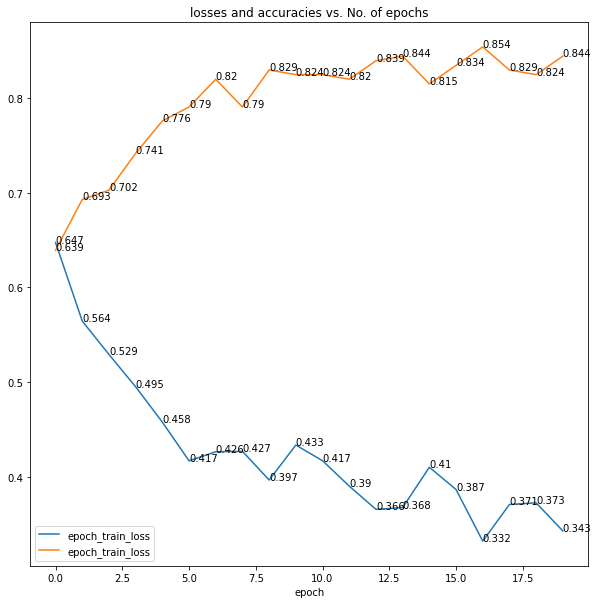

In [78]:
print(cnn_train_accuracy)
print(cnn_train_loss)



In [10]:
# torch.save(model, path_cnn)
cnn_train_loss = [0.6472067001389294, 0.5643139141361888, 0.529077311841453, 0.4949626261141242, 0.45765624017250245, 0.4168072915658718, 0.4263936728965945, 0.42690800413852786, 0.3965878855891344, 0.43348362409487, 0.416932646966562, 0.3901914365407897, 0.36564615045378845, 0.36750619665878576, 0.4100591588311079, 0.38653764652042855, 0.33214051832513114, 0.37077500115080575, 0.37251478942429145, 0.3428186601981884]
cnn_train_accuracy = [tensor(0.6390, dtype=torch.float64), tensor(0.6927, dtype=torch.float64), tensor(0.7024, dtype=torch.float64), tensor(0.7415, dtype=torch.float64), tensor(0.7756, dtype=torch.float64), tensor(0.7902, dtype=torch.float64), tensor(0.8195, dtype=torch.float64), tensor(0.7902, dtype=torch.float64), tensor(0.8293, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8195, dtype=torch.float64), tensor(0.8390, dtype=torch.float64), tensor(0.8439, dtype=torch.float64), tensor(0.8146, dtype=torch.float64), tensor(0.8341, dtype=torch.float64), tensor(0.8537, dtype=torch.float64), tensor(0.8293, dtype=torch.float64), tensor(0.8244, dtype=torch.float64), tensor(0.8439, dtype=torch.float64)]
plot_accuracies(cnn_train_loss, 'epoch_train_loss')
plot_accuracies(cnn_train_accuracy, 'epoch_train_loss')

TypeError: new() received an invalid combination of arguments - got (float, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [69]:
model = ConvNet(224)
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model = ConvNet(224)
# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_model1(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = {
        "epoch_train_loss": [],
        "epoch_train_accuracy": [],
        "epoch_val_accuracy": [],
        "epoch_val_loss": [],
        
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_total_steps = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'test']:
            if (phase == 'train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0


            for i, (images, labels) in enumerate(dataloaders[phase]):
                
                # images = images.to(device)
                # labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                print(outputs.shape)
                print(labels.shape)
                print(preds.shape)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train':
                    scheduler.step()

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]
                    history["epoch_train_loss"].append(epoch_loss)
                    history["epoch_train_accuracy"].append(epoch_acc)

                if phase == 'test':
                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]
                    history["epoch_val_loss"].append(epoch_loss)
                    history["epoch_val_accuracy"].append(epoch_acc)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

            
                if (i+1) % 10 == 0:
                    # print("hi")
                # break
                    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv_self = ConvNet(224)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv_self.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

path_cnn =  'models_trained/cnn_self_defined.pth'
# train loop
model_conv = train_model1(model_conv_self, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

torch.save(model_conv, path_cnn)
print(f"model saved at path {path_cnn}")

Epoch 0/9
----------
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0135 Acc: 0.0098
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0270 Acc: 0.0195
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0409 Acc: 0.0244
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0543 Acc: 0.0341
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0671 Acc: 0.0537
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0790 Acc: 0.0732
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.0912 Acc: 0.0878
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.1062 Acc: 0.0927
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.1198 Acc: 0.1024
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.1337 Acc: 0.1122
Epoch [1/10], Step [10/52], Loss: 0.7099
torch.Size([4, 2])
torch.Size([4])
torch.Size([4])
train Loss: 0.1447 Acc: 0.1268
torch.Size([4, 2])
torch.Size([4])
t

RuntimeError: shape '[-1, 186624]' is invalid for input of size 984064

### train loop

In [21]:
# need them for plotting
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []
epoch_val_loss = []

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_train_loss.append(epoch_loss)
                epoch_train_accuracy.append(epoch_acc)

            if phase == 'test':
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                epoch_val_loss.append(epoch_loss)
                epoch_val_accuracy.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [16]:
# need them for plotting
epoch_train_loss = []
epoch_train_accuracy = []
epoch_val_accuracy = []
epoch_val_loss = []

### transfer learning

In [24]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
# freeze 
for param in model_conv.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


### train model

In [28]:
# path =  'models_trained/resnet18_hyphaAug4.pth'
path =  'models_trained/resnet18-1.pth'

In [29]:
# train loop
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=10)

torch.save(model_conv, path)
print(f"model saved at path {path}")

Epoch 0/9
----------
train Loss: 0.2754 Acc: 0.8976
test Loss: 0.1628 Acc: 0.9231

Epoch 1/9
----------
train Loss: 0.2525 Acc: 0.9073
test Loss: 0.1614 Acc: 0.9231

Epoch 2/9
----------
train Loss: 0.3521 Acc: 0.8439
test Loss: 0.2175 Acc: 0.8846

Epoch 3/9
----------
train Loss: 0.3094 Acc: 0.8585
test Loss: 0.1636 Acc: 0.9231

Epoch 4/9
----------
train Loss: 0.2767 Acc: 0.9024
test Loss: 0.1968 Acc: 0.9038

Epoch 5/9
----------
train Loss: 0.3230 Acc: 0.8634
test Loss: 0.1741 Acc: 0.9423

Epoch 6/9
----------
train Loss: 0.2580 Acc: 0.8829
test Loss: 0.1811 Acc: 0.9423

Epoch 7/9
----------
train Loss: 0.2929 Acc: 0.8829
test Loss: 0.1795 Acc: 0.9038

Epoch 8/9
----------
train Loss: 0.3330 Acc: 0.8634
test Loss: 0.1742 Acc: 0.9423

Epoch 9/9
----------
train Loss: 0.3393 Acc: 0.8585
test Loss: 0.1643 Acc: 0.9423

Training complete in 1m 43s
Best val Acc: 0.942308
model saved at path models_trained/resnet18-1.pth


In [26]:
### plot all 4 across epoch:
plt.rcParams['figure.figsize'] = [10, 10]
def plot_accuracies(some_list, y_label):
    plt.plot(some_list, label=y_label)
    plt.xlabel('epoch')
    plt.title('losses and accuracies vs. No. of epochs');
    plt.legend(loc='lower left')

    # annotate graph
    for i in range(len(some_list)):
        plt.annotate(round(float(some_list[i]),3), (i,some_list[i]))
    


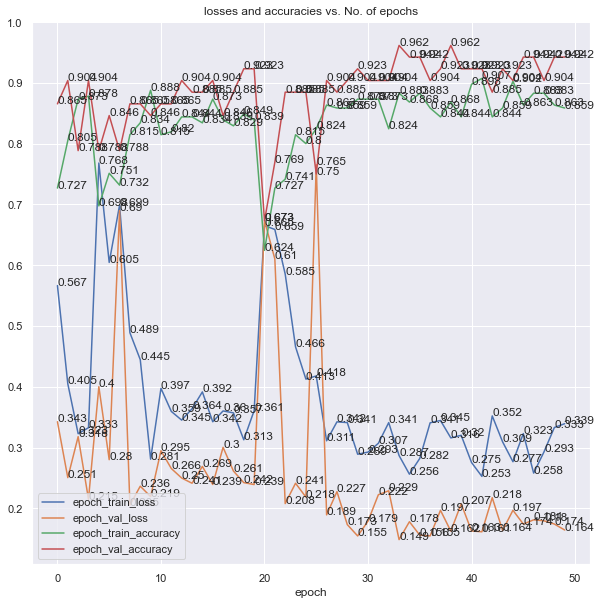

In [30]:
# path =  'models_trained/resnet18_hyphaAug4.pth'
# RESNET18
plot_accuracies(epoch_train_loss, 'epoch_train_loss')
plot_accuracies(epoch_val_loss, 'epoch_val_loss')
plot_accuracies(epoch_train_accuracy, 'epoch_train_accuracy')
plot_accuracies(epoch_val_accuracy, 'epoch_val_accuracy')

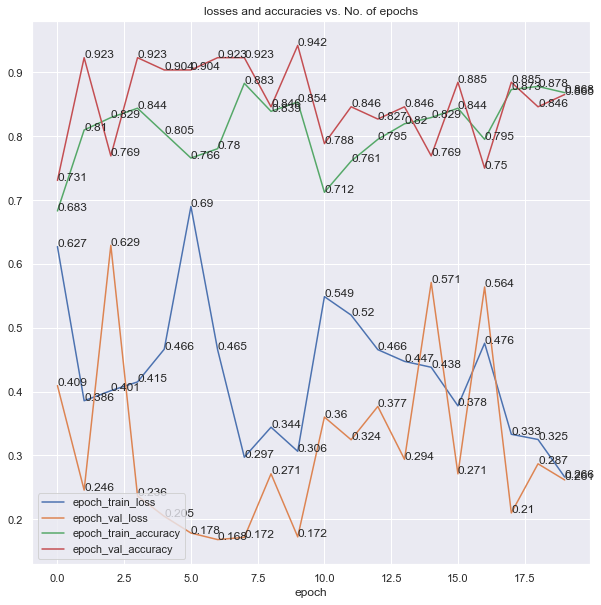

In [80]:
# RESNET50
# path =  'models_trained/resnet50_hyphaAug1.pth'
plot_accuracies(epoch_train_loss, 'epoch_train_loss')
plot_accuracies(epoch_val_loss, 'epoch_val_loss')
plot_accuracies(epoch_train_accuracy, 'epoch_train_accuracy')
plot_accuracies(epoch_val_accuracy, 'epoch_val_accuracy')

### Evaluation

In [6]:
## load model
path1 = 'models_trained/resnet18_hyphaAug4.pth'
path2 =  'models_trained/resnet50_hyphaAug1.pth'
loaded_model1 = torch.load(path1)
loaded_model2 = torch.load(path2)
loaded_model1.eval()
loaded_model2.eval()
# for param in loaded_model.parameters():
#     print(param)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# evaluation
@torch.no_grad()
def get_all_preds(model, loader):
    # all_preds = torch.tensor([])
    all_preds = []
    all_labels = []
    for batch in loader:
        images, labels = batch
        outputs = model(images)
        print(outputs)
        _, preds = torch.max(outputs, 1)
        print(f"prediction: {preds}")
        print(f"labels: {labels}")
        for pred in preds:
            # print(pred)
            all_preds.append(pred.item())
        for label in labels:
            all_labels.append(label)
        
        # all_preds = torch.cat(
        #     (all_preds, preds)
        #     ,dim=0
        # )
        # all_preds = torch.cat(preds)
        # all_preds.append(preds)

        # print(all_preds)
        print(len(all_preds)) # 52 if using test dataloader
        print(len(all_labels))
        break
    return all_preds, all_labels


tensor([[-2.2631,  3.4231],
        [ 1.2931,  0.1418],
        [-2.0688,  2.7730],
        [ 2.2265, -1.1065]])
prediction: tensor([1, 0, 1, 0])
labels: tensor([1, 0, 1, 0])
4
4
[[2 0]
 [0 2]]
[tensor(1), tensor(0), tensor(1), tensor(0)]
[1, 0, 1, 0]
4
4.0


Accuracy=1.000
Precision=1.000
Recall=1.000
F1 Score=1.000


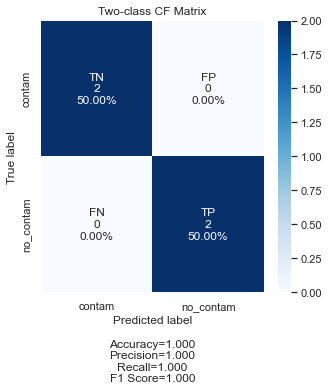

In [11]:
with torch.no_grad():
    # prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds, train_labels = get_all_preds(loaded_model1, dataloaders['test'])

cfm = confusion_matrix(train_preds, train_labels)
print(cfm)
labels = ['TN','FP','FN','TP']
print(train_labels)
sns.set(rc={'figure.figsize':(5,5)})
print(train_preds)
cf_matrix.make_confusion_matrix(cfm, group_names=labels, categories=class_names, cmap='Blues', title='Two-class CF Matrix')
# dk why these stats not showing in my matrix

if len(cfm)==2:
    # Metrics for Binary Confusion Matrices
    accuracy  = np.trace(cfm) / float(np.sum(cfm))
    print(np.trace(cfm) )
    print((float(np.sum(cfm))))
    precision = cfm[1,1] / sum(cfm[:,1])
    recall    = cfm[1,1] / sum(cfm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
print(stats_text)
plt.show()

prediction: tensor([1, 0, 1, 0])
labels: tensor([1, 0, 1, 0])
4
4
prediction: tensor([0, 1, 1, 0])
labels: tensor([0, 1, 1, 0])
8
8
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 0])
12
12
prediction: tensor([1, 1, 1, 0])
labels: tensor([1, 1, 1, 0])
16
16
prediction: tensor([0, 0, 0, 1])
labels: tensor([1, 0, 1, 1])
20
20
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
24
24
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
28
28
prediction: tensor([0, 1, 0, 0])
labels: tensor([1, 1, 0, 0])
32
32
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 1])
36
36
prediction: tensor([1, 1, 1, 1])
labels: tensor([1, 1, 1, 1])
40
40
prediction: tensor([1, 0, 0, 1])
labels: tensor([1, 0, 0, 1])
44
44
prediction: tensor([1, 1, 0, 0])
labels: tensor([1, 1, 0, 1])
48
48
prediction: tensor([0, 1, 1, 0])
labels: tensor([1, 1, 1, 0])
52
52
[[16  5]
 [ 1 30]]
[tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), t

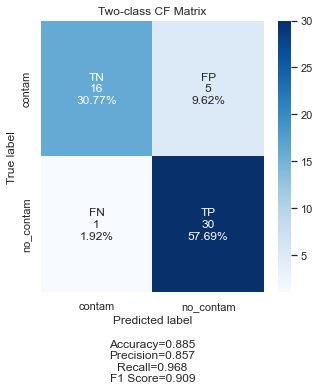

In [88]:
with torch.no_grad():
    # prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds, train_labels = get_all_preds(loaded_model2, dataloaders['test'])

cfm = confusion_matrix(train_preds, train_labels)
print(cfm)
labels = ['TN','FP','FN','TP']
print(train_labels)
sns.set(rc={'figure.figsize':(5,5)})
print(train_preds)
cf_matrix.make_confusion_matrix(cfm, group_names=labels, categories=class_names, cmap='Blues', title='Two-class CF Matrix')
# dk why these stats not showing in my matrix

if len(cfm)==2:
    # Metrics for Binary Confusion Matrices
    accuracy  = np.trace(cfm) / float(np.sum(cfm))
    print(np.trace(cfm) )
    print((float(np.sum(cfm))))
    precision = cfm[1,1] / sum(cfm[:,1])
    recall    = cfm[1,1] / sum(cfm[1,:])
    f1_score  = 2*precision*recall / (precision + recall)
    stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
        accuracy,precision,recall,f1_score)
print(stats_text)
plt.show()

### inference stuffs

In [ ]:
# def predict_image(img, model):
#     # Convert to a batch of 1
#     xb = img.unsqueeze(0), device
#     # Get predictions from model
#     yb = model(xb)
#     # Pick index with highest probability
#     _, preds  = torch.max(yb, dim=1)
#     # Retrieve the class label
#     return train_ds.classes[preds[0].item()]

In [113]:
# FOR 1 SINGLE SAMPLE
img, label = image_datasets['test'][45]
print(f"initial image shape: {img.shape} ")
print(f"label: {label} ")

# Convert to a batch of 1 to feed into the model properly
outputs = loaded_model1(img.unsqueeze(0))
_, pred = torch.max(outputs, 1)
print(pred)
class_predicted = class_names[pred]

initial image shape: torch.Size([3, 256, 256]) 
label: 1 
tensor([1])


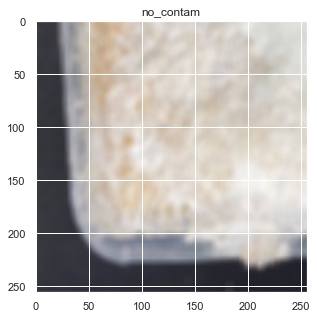

In [117]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Make a grid from batch(prob not required if single img)
out = torchvision.utils.make_grid(img)
imshow(out, class_predicted)